rtl_sdr_fm_audio_2024_hw3

This captures an FM radio signal of a specified duration, demodulates it in a very simple fashion, and plays the audio over the computer's speaker.

In [1]:
4+2 # Test if kernel is running

6

In [2]:
import time
import numpy as  np
import matplotlib.pyplot as plt
import sounddevice as sd
from copy import copy
np.set_printoptions(precision=2)

In [3]:
# Close old SDR instance
# Need to do this before you can adjust sampling frequency
# Drivers must be installed for this to work
# If this gives an error (eg because another program is controlling
# the SDR), close the other program and restart this kernel
from rtlsdr import RtlSdr 
# Close previous instances of the sdr object
try: 
    sdr.close()
    print("Closed old SDR")
except NameError:
   print("No SDR instance found")

No SDR instance found


In [4]:
sdr = RtlSdr() # Create a new sdr object (by keeping this in 
               # the block above can be used to close sdr without
               # creating a new sdr instance, which you might want to
               # do when switching to a new program
               # If this fails (eg with "usb_claim_interface error -3" on Mac), try 
               # (1) Unpluging and re-inserting the RTL SDR device
               # (2) running close block above
               # (3) closing other programs that may be using SDR
               # (4) restarting this kernel
               # If you see "PLL not locked!" that is normal behavior...not a problem.

Found Rafael Micro R820T/2 tuner


In [ ]:
# Don't run this cell unless you are about to quit.
sdr.close()

In [5]:
# Making samples per sec a multiple of 256 means that if
# we sample for simple multiples of 1 s, our number of samples
# will be multiples of 256, which is a requirement
fsps = 256*256*16 # = 1048576 ... about 1Msps...works
#fsps = 2*256*256*16 # =  ... about 2Msps...works
faudiosps =48000 # audio sampling frequency (for output)

fc = 94.9e6 # KUOW Seattle
#fc = 90.3e6 # Some Seattle station
#fc = 92.5e6 # Spanish language station at 92.5

# specify sampling frequency
dt = 1.0/fsps # time step size between samples
nyquist = fsps /2.0

#Tmax = 10.0       # 10 s
#Tmax = 5.0        # 5 s
Tmax = 2.5         # 2.5 s
#Tmax = 1.0        # 1 s
#Tmax = 0.125      # 1/8  s = 125ms
#Tmax = 0.0625     # 1/16 s = 62 ms 
#Tmax = 0.03125    # 1/32 s = 31 ms
#Tmax = 0.015625   # 1/64 s = 16 ms
#Tmax = 0.0078125  # 1/128s = 7.8ms
#Tmax = 0.00390625 # 1/256s = 3.9ms

N = round(fsps*Tmax) # N must be a multiple of 256
print("The number of samples to collect, N= ",N)

sdr.sample_rate = fsps 
sdr.center_freq = fc

print("The valid gains are")
print(sdr.valid_gains_db)
#sdr.gain = 'auto'
sdr.gain = 42.0 # This is max on rtl_sdr v4, according to sdr.valid_gains_db
print("We are using ")
print("Gain (0==auto)  : ", sdr.gain)
print("Sample Rate     : ", sdr.sample_rate)
print("Center frequency: ", sdr.center_freq)

The number of samples to collect, N=  2621440
The valid gains are
[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]
We are using 
Gain (0==auto)  :  42.1
Sample Rate     :  1048576.0
Center frequency:  94900000


In [6]:
#***
# Collect samples
samples = ((np.zeros((N))+1j)-1j) # Trick it into being an array of complex zeros
print("Sampling with center frequency ", fc, " for ", Tmax, " seconds")
sdr.center_freq = fc
print("Frequency spans from ", (fc-nyquist)/1e6," to ", (fc+nyquist)/1e6,"MHz")
print("SDR gain:", sdr.gain)
samples = sdr.read_samples(N) # Collect N samples...N must be multiple of 256end_time = time.time()

Sampling with center frequency  94900000.0  for  2.5  seconds
Frequency spans from  94.375712  to  95.424288 MHz
SDR gain: 42.1


In [7]:
# Optional: Save the arrays to a file
np.savez('savefile-2024-04-25-00-00', samples=samples)

In [8]:
# Optional: Load the arrays from the file
data = np.load('savefile-2024-04-25-00-00.npz')
samples = data['samples']
N = len(samples)

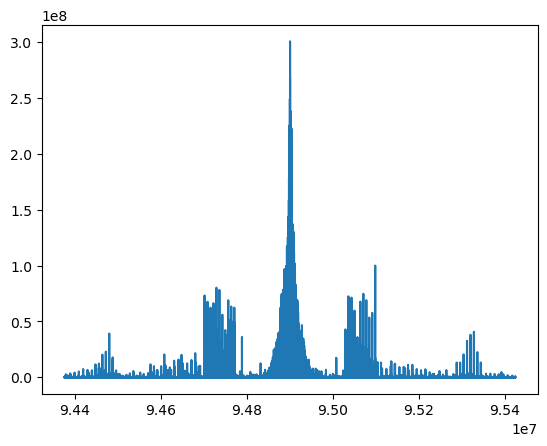

In [9]:
#***
# Compute and plot the spectrum for the samples just collected
freqs = np.zeros((N))
spectrum = ((np.zeros((N))+1j)-1j)

plt.figure()
spectrum = np.fft.fftshift(np.fft.fft(samples))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
plt.plot(freqs,np.abs(spectrum*spectrum.conjugate()));

In [10]:
# stopband width, passband width, passband full width (double sided)
#
#      sbw        pbfw       sbw
#   --------+++++++++++++--------
#           -fc          fc
#  -nyq            0             +nyq
# returns a length N vector consisting  
# ones in the middle, padded by zeros on the left and right
# fcutoff is the one-sided cutoff frequency
# so if fcutoff is 100kHz, the pass band will extend from 
# bin N/2 - 100kHz to bin N/2 + 100kHz
def bandpassmask(N,fsps,fcutoff):
    fcutoff_n = fcutoff / fsps # fcutoff, normalized
    pbfw = round(2*fcutoff_n*N)
    sbw = int((N-pbfw)/2)
    print("N= ", N, " fsps= ",fsps, " fcutoff=", fcutoff, " fcutoff_n= ",fcutoff_n," pbfw= ", pbfw, " sbw= ", sbw)
    res = np.concatenate((np.zeros(sbw),np.ones(pbfw),np.zeros(sbw)))
    print("total= ",pbfw+sbw+sbw)
    return(res)

N=  2621440  fsps=  1048576  fcutoff= 100000  fcutoff_n=  0.095367431640625  pbfw=  500000  sbw=  1060720
total=  2621440


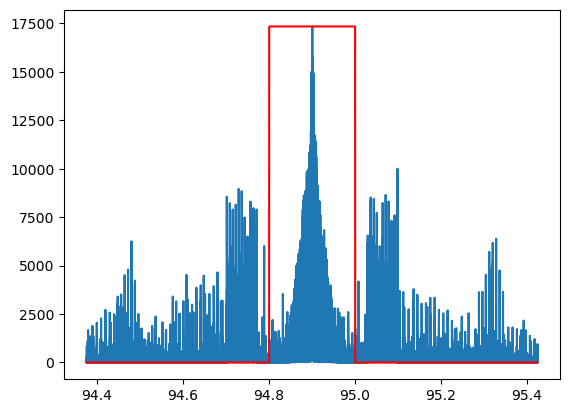

In [11]:
# Create and plot the bandpass mask
fcutoff = 100000 # Cutoff frequency of filter 100kHz
bpm = bandpassmask(N,fsps,fcutoff) # create the bandpass mask
plt.figure()
height = np.max(np.abs(spectrum))
plt.plot(freqs/1e6,np.abs(spectrum))
plt.plot(freqs/1e6,height*bpm,'r');

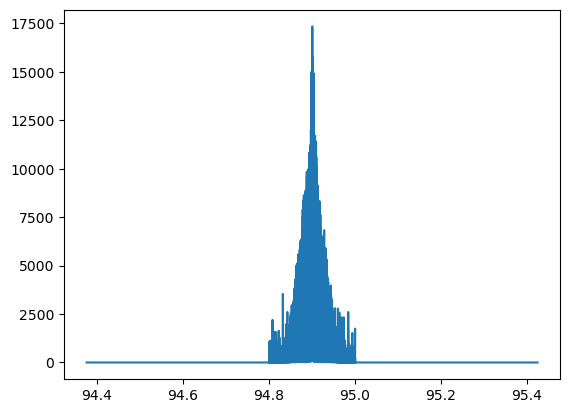

In [12]:
#***
# Filter by applying frequency mask to spectrum
filteredspectrum = spectrum * bpm
plt.plot(freqs/1e6,np.abs(filteredspectrum));

In [13]:
#***
# Convert masked spectrum back to time domain to get filtered signal 
filteredsignal = np.fft.ifft(np.fft.fftshift(filteredspectrum)) # Good results

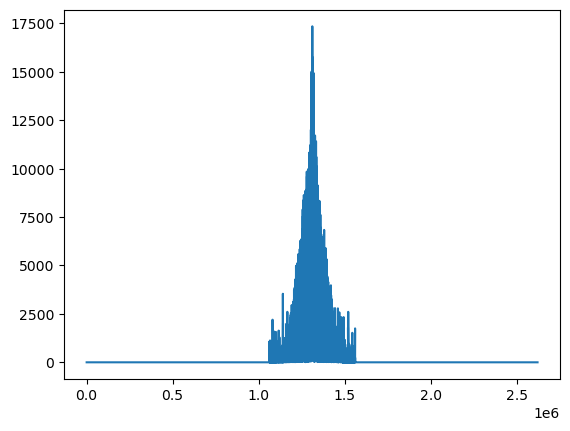

In [14]:
# For validation, also convert from time back to freq to make sure 
# we didn't mess something up (ie to make sure we get back spectrum)
# we started with
validatefilteredsignal = np.fft.fftshift(np.fft.fft(filteredsignal))
plt.figure()
plt.plot(np.abs(validatefilteredsignal));

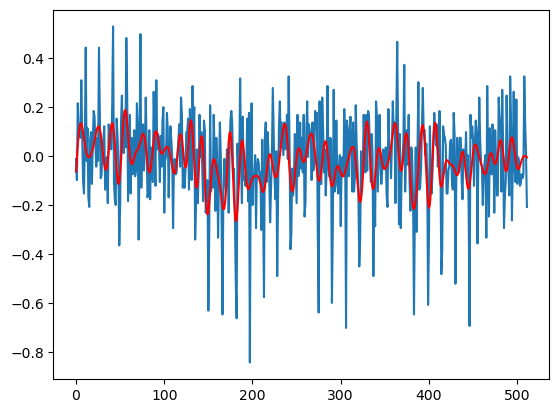

In [15]:
# Compare time domain view of filtered and un-filtered signal
plt.figure()
plt.plot(np.real(samples[0:512]))
plt.plot(np.real(filteredsignal[0:512]),'r');

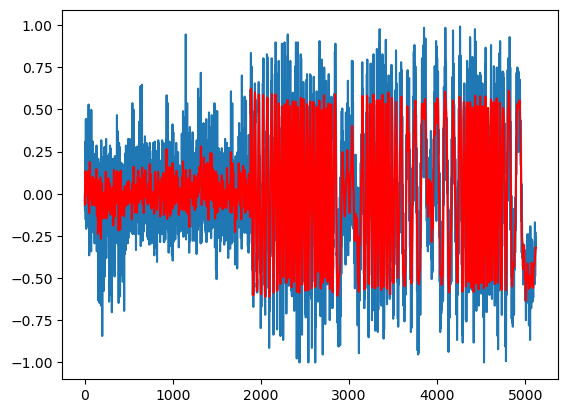

In [16]:
# Same as above, but longer time window
plt.figure()
plt.plot(np.real(samples[0:5120]))
plt.plot(np.real(filteredsignal[0:5120]),'r');

# Find $\frac{d\theta}{dt},$ the derivative of the phase $\theta$

First find the phase $\theta$ from the complex signals

In [17]:
#***
#theta = np.angle(filteredsignal)
theta = np.arctan2(filteredsignal.imag,filteredsignal.real)

# Squelch

In [18]:
abssignal = np.abs(filteredsignal)
meanabssignal = np.mean(abssignal)
thetasquelched = copy(theta)
filteredsquelched = copy(filteredsignal)
squelchthresh = (meanabssignal/3.0)
for i in range(N):
    if (abssignal[i]<squelchthresh):
        filteredsquelched[i] = 0.0
        thetasquelched[i] = 0.0

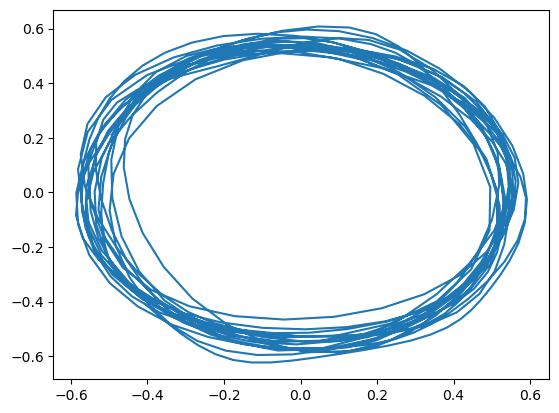

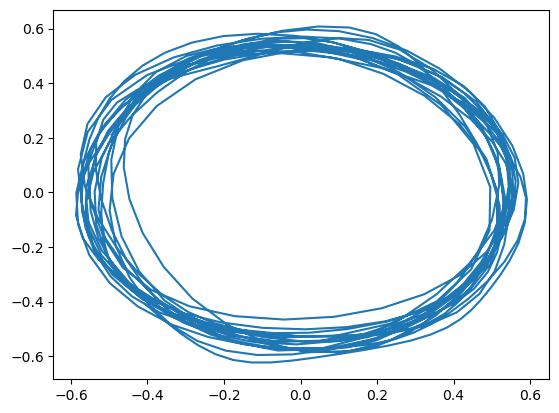

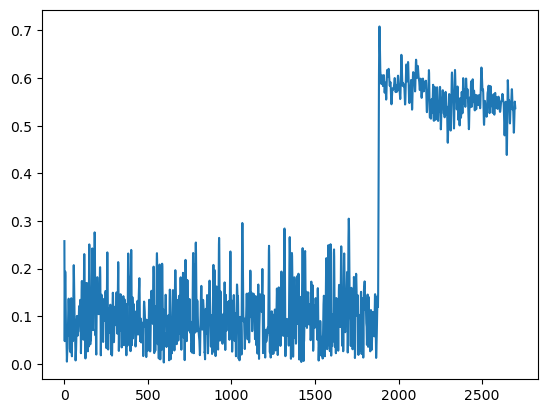

In [19]:
mins = int(2.1e3)
maxs = int(2.7e3)
alphaval = 1.0
#alphaval = 0.005
plt.figure()
plt.plot(filteredsignal[mins:maxs].real,filteredsignal[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
plt.plot(filteredsquelched[mins:maxs].real,filteredsquelched[mins:maxs].imag,alpha=alphaval) # line
plt.figure()
plt.plot(np.abs(filteredsignal[0:maxs]));

# Find $\frac{d\theta}{dt}$
Note: np.convolve([1,-1]) computes the derivative 

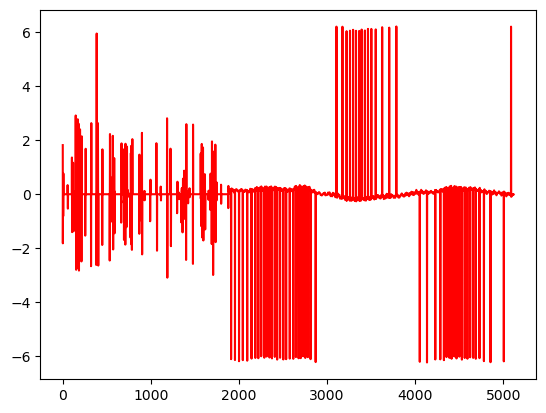

In [20]:
# Compute derivative of theta signal
# deriv (theta plus 0)
derivthetap0 = np.convolve([1,-1],thetasquelched,'same')
plt.figure()
plt.plot(derivthetap0[0:5120],'r');

# Eliminate phase wrap errors

Method 1: the 0, +pi comparison method

In [21]:
# The 0, +pi comparison method
# deriv (theta plus pi)
derivthetapp = np.convolve([1,-1],(thetasquelched+np.pi) % (2*np.pi),'same') # Compute derivative of {theta+pi}
derivtheta = np.zeros(len(derivthetap0))
for i in range(len(derivthetap0)):
    if (abs(derivthetap0[i])<abs(derivthetapp[i])): # pick whichever is smaller: deriv{theta} or deriv{theta+pi}
        derivtheta[i] = derivthetap0[i] 
    else:
        derivtheta[i] = derivthetapp[i] 
cdtheta = copy(derivtheta)

In [22]:
spikethresh = 2
# First let's look in detail at the first few spikes
for i in range(1000):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])

147    2.91752175038976
152    -2.7995478259842552
165    -2.72324307240447
170    2.777998987361062
179    2.615007580423986
184    -2.8294140868579394
196    2.4030564842287254
199    -2.2331204431071967
212    -2.491139712955194
216    2.143927754987085
321    -2.6670047217733206
324    2.634195584271904
380    -2.6205463938003546
385    5.953535549170406
399    2.634009357600755
403    -2.6430555268961355
533    -2.4571376731067107
536    2.2296977596767387
568    2.1646447747965087
572    -2.046688380321812
785    -2.0611275336081243
790    2.0407823769552156
899    2.2738689436232997
901    -2.229287423447825


In [23]:
# and the last spikes
for i in range(len(derivtheta)-1000,len(derivtheta)):
  if (abs(derivtheta[i]) > (spikethresh)):
    print(i,"  ",derivtheta[i])

2620459    6.165994121881196
2620492    6.099651243782658
2620537    6.083240973934548
2620594    6.141933506665843
2620756    6.234916022718077
2620914    6.214880573214093
2621001    -6.185458294473246
2621091    -6.1862882562263835
2621164    -6.132354129048683
2621237    -6.179423738683504
2621343    -6.173594560540538


Method 2: spike removal

Pick threshold (spikethresh) large enough that the phase-wrap spikes are isolated...that will mean we can remove them nicely by averaging their neighbors. (Why wouldn't they be? Maybe noise could cause some weird things to happen, like bouncing back and forth across the $0-2 \pi$ phase wrap boundary a few times in a row? 

In [24]:
#***
#cdtheta = copy(derivthetap0) # Cleaned derivative of theta
cdtheta = copy(derivtheta) # Cleaned derivative of theta
for i in range(1,len(derivtheta)-1):
    if (abs(derivtheta[i])>spikethresh):
        cdtheta[i] = (derivtheta[i-1]+derivtheta[i+1])/2.0

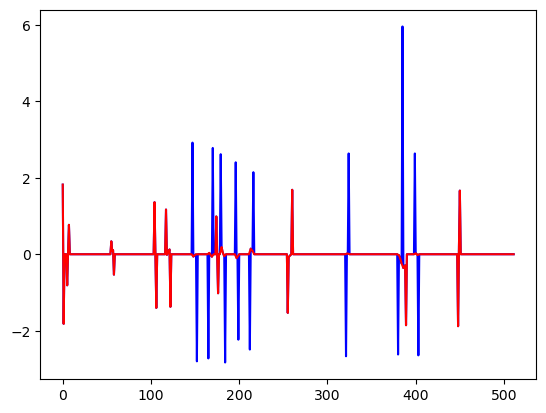

In [25]:
plt.figure()
plt.plot(derivtheta[0:512],'b');
plt.plot(cdtheta[0:512],'r');

Now we will look at plots to compare the cleaned signals (with phase wrap artifacts removed) and raw un-cleaned signals.


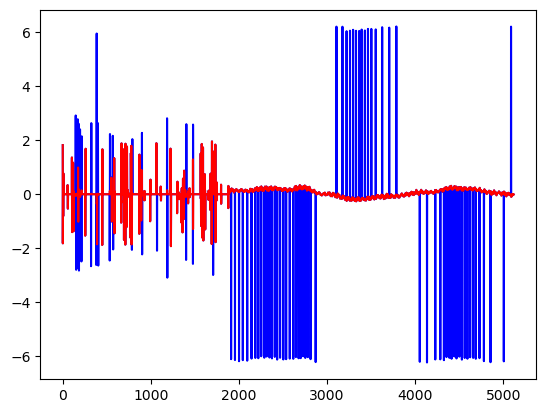

In [26]:
plt.figure()
plt.plot(derivtheta[0:5120],'b')
plt.plot(cdtheta[0:5120],'r');

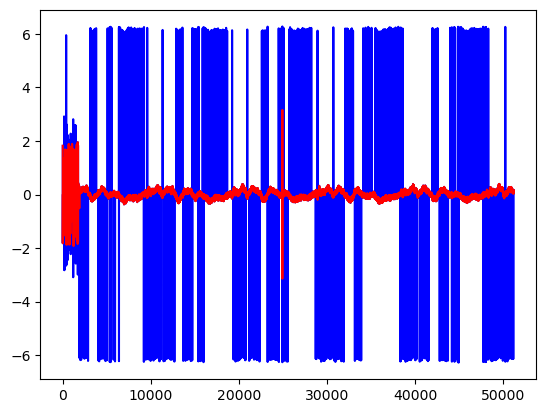

In [27]:
plt.figure()
plt.plot(derivtheta[0:51200],'b')
plt.plot(cdtheta[0:51200],'r');

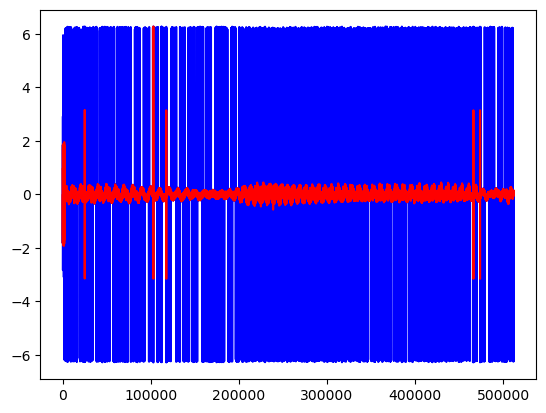

In [28]:
plt.figure()
plt.plot(derivtheta[0:512000],'b')
plt.plot(cdtheta[0:512000],'r');

The plot above shows that the cleaning had a huge effect!

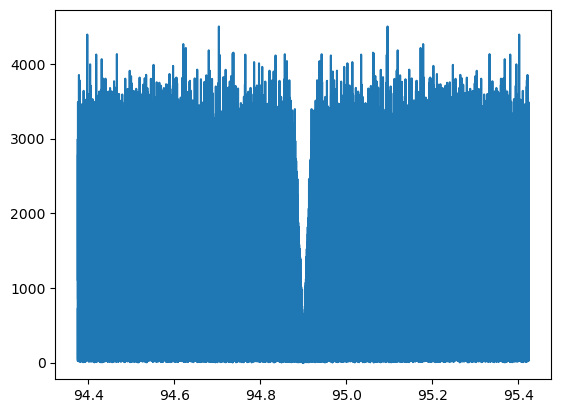

In [29]:
# In the frequency domain, getting rid of the wrap around errors is
# even more obvious
# With wrap around errors
FTderivtheta=np.fft.fftshift(np.fft.fft(derivtheta))
plt.figure
plt.plot(freqs/1e6,np.abs(FTderivtheta));

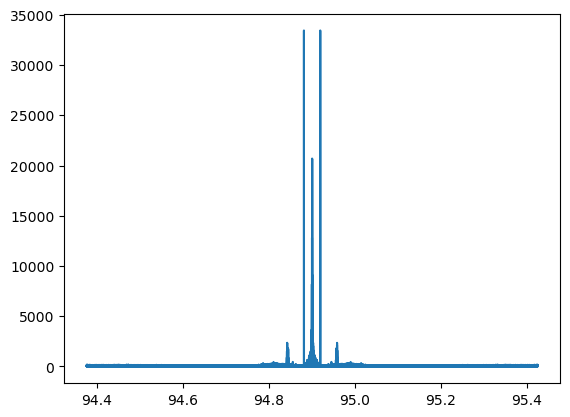

In [30]:
# Without wraparound errors
FTcdtheta=np.fft.fftshift(np.fft.fft(cdtheta))
plt.figure
plt.plot(freqs/1e6,np.abs(FTcdtheta));

In the frequency domain the cleaned & uncleaned signals look drastically different! Those spikes were really messing things up.

### Downsampling
Our RF samples are about 1Msps (one million samples per second)...our audio sub-system only plays about 48000 sps...so we need to downsample, ie throw away samples. First we'll look at Python notation for downsampling, and then we'll figure out how many samples we need to throw away

In [31]:
# How much do we need to downsample?
# Let's figure out the required downsampling factor
# For example, suppose we need to turn 1048576 sps into 48000 sps
# then the downsampling ratio = 1048576/48000
dsf = round(fsps/faudiosps) # round(1048576/48000)
print("Down sampling factor is", dsf)

Down sampling factor is 22


In [32]:
#*** DownSampled Cleaned Derivative of Theta
# Just keep every 44th sample
dscdtheta = cdtheta[::dsf] # downsample by dsf-th sample (or whatever dsf is)

In [54]:
#Better: Average in blocks of dsf
dscdtheta2 = copy(dscdtheta)
for i in range(len(dscdtheta2)):
    dscdtheta2[i] = np.sum(cdtheta[i*dsf:(i+1)*dsf])/dsf
print("Length before downsampling: ",len(cdtheta))
print("Length after downsampling : ",len(dscdtheta2))
dscdtheta = copy(dscdtheta2)

Length before downsampling:  2621440
Length after downsampling :  119157


In [38]:
# New proposed method: Moving average with np.convolve and then downsample
faudiosps = 48000

window = np.ones(dsf) / dsf  # averaging window
convolved_signal = np.convolve(cdtheta, window, mode='valid')  # moving average
dscdtheta = convolved_signal[::dsf]  # downsample by keeping every dsf-th sample

In [39]:
# Let's figure out the horizontal scale of the FT of the audio
faudionyquist = faudiosps/2.0
freqsaudio = np.linspace(-faudionyquist,+faudionyquist,len(dscdtheta))

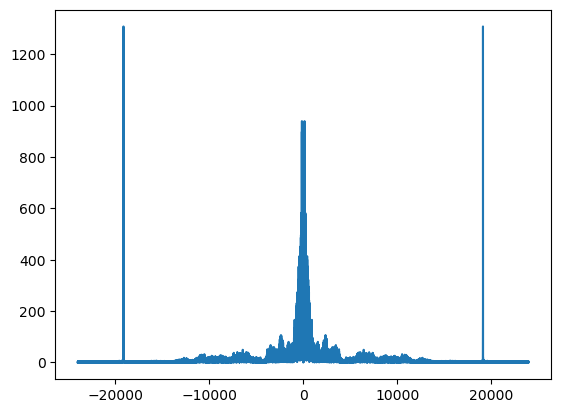

In [40]:
# FourierTransform of DownSampled Cleaned Derivative of Theta
FTdscdtheta=np.fft.fftshift(np.fft.fft(dscdtheta))
plt.figure
plt.plot(freqsaudio,np.abs(FTdscdtheta));

In [41]:
# Play Audio
#faudiosps defined at top (eg 48000)
dt_audio = 1/faudiosps
myaudio = dscdtheta
start_time = time.time()
sd.play(10*myaudio,faudiosps,blocking=True)